In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from neuralforecast.losses.pytorch import BasePointLoss, _weighted_mean
import torch
from typing import Union
import warnings
import matplotlib.pyplot as plt

In [2]:
# Define the file name
file_path = 'BasicInputTimeSeries.npy'

# Check if the file exists
if os.path.exists(file_path):
    # Load the .npy file with allow_pickle=True
    time_series_data = np.load(file_path, allow_pickle=True)
    print("Data loaded from file.")
else:
    print("File not found.")


Data loaded from file.


In [3]:
#-------------------------------------------------------------
seed = 100
# Set the random seed for Python's random module
random.seed(seed)
# Set the random seed for NumPy
np.random.seed(seed)
print('seed :',seed)
#-------------------------------------------------------------

    
# Define the column names
columns = ["Year_Mnth_Day", "basin_id", "prcp(mm/day)", "srad(W/m2)", "tmax(C)", "tmin(C)", "vp(Pa)", "QObs(mm/d)"]
# Create the DataFrame
df = pd.DataFrame(time_series_data, columns=columns)

# Deleting the numpy array from memory
del time_series_data

df['ds'] = pd.to_datetime(df['Year_Mnth_Day'])
df['unique_id'] = df['basin_id']
df['y'] = df['prcp(mm/day)'].astype(float)
df.drop(['Year_Mnth_Day', 'basin_id', "prcp(mm/day)", ], axis=1, inplace=True) # "srad(W/m2)", "tmax(C)", "tmin(C)", "vp(Pa)", "QObs(mm/d)"

# for col in df.columns:
#     print(col)
#     if col != 'ds' and col !='unique_id':
#         # Global Normalization
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         df[col] = scaler.fit_transform(df[[col]])


# Sort the DataFrame by 'unique_id' and 'ds' to ensure correct order
df.sort_values(by=['unique_id', 'ds'], inplace=True)

# Function to split each group
def split_train_test(data, n):
    train_frames = []
    test_frames = []
    for _, group in data.groupby('unique_id'):
        train, test = group[:-n], group[-n:]
        train_frames.append(train)
        test_frames.append(test)
    train_df = pd.concat(train_frames)
    test_df = pd.concat(test_frames)
    train_df.reset_index(inplace=True, drop=True)
    test_df.reset_index(inplace=True, drop=True)
    return train_df, test_df

# Function to drop the last n values fron each group
def drop_last_n(data, n):
    train_frames = []
    for _, group in data.groupby('unique_id'):
        train = group[:-n]
        train_frames.append(train)
    train_df = pd.concat(train_frames)
    train_df.reset_index(inplace=True, drop=True)
    return train_df


    
# Set 'ds' as the index if you plan to use time-based indexing
df.set_index('ds', inplace=True, drop=False)

# # Function to calculate EMA for each group
# def calculate_ema(group, span):
#     return group.ewm(span=span, adjust=False).mean()

# # Apply the function to each group for multiple spans
# span_settings = [2, 4, 6, 8, 10, 20, 50]  # Example spans
# for span in span_settings:
#     print(f'EMA_{span}')
#     df[f'EMA_{span}'] = df.groupby('unique_id')['y'].transform(lambda x: calculate_ema(x, span))
    
df.reset_index(inplace=True, drop=True)
   
    
# Number of records to be taken as test data for each unique_id
n = 3000 
n_time_series = 671
len_time_series = 7000
_, df = split_train_test(df, len_time_series)

train_df, test_df = split_train_test(df, n)


print("DataFrame:")
print(df)



seed : 100
DataFrame:
        srad(W/m2) tmax(C) tmin(C)  vp(Pa)  QObs(mm/d)         ds unique_id  \
0           237.53   12.75   -1.37  599.13    0.376714 1989-11-02   1013500   
1            99.59     8.1   -0.31  561.45    0.379961 1989-11-03   1013500   
2           129.07    3.35   -4.01  425.97    0.397282 1989-11-04   1013500   
3           193.49   -0.75   -9.83   303.0    0.405942 1989-11-05   1013500   
4           159.91    3.82   -5.66  425.19    0.422179 1989-11-06   1013500   
...            ...     ...     ...     ...         ...        ...       ...   
4696995     125.72    4.86    0.39  604.28   22.806309 2008-12-27  14400000   
4696996     101.25    6.06    2.83  702.39  115.775145 2008-12-28  14400000   
4696997     140.54    7.87    2.46  703.56  134.606043 2008-12-29  14400000   
4696998     171.69    6.96   -3.14  532.92    54.40037 2008-12-30  14400000   
4696999     174.73    8.15    0.13  599.32   29.920203 2008-12-31  14400000   

              y  
0          

y


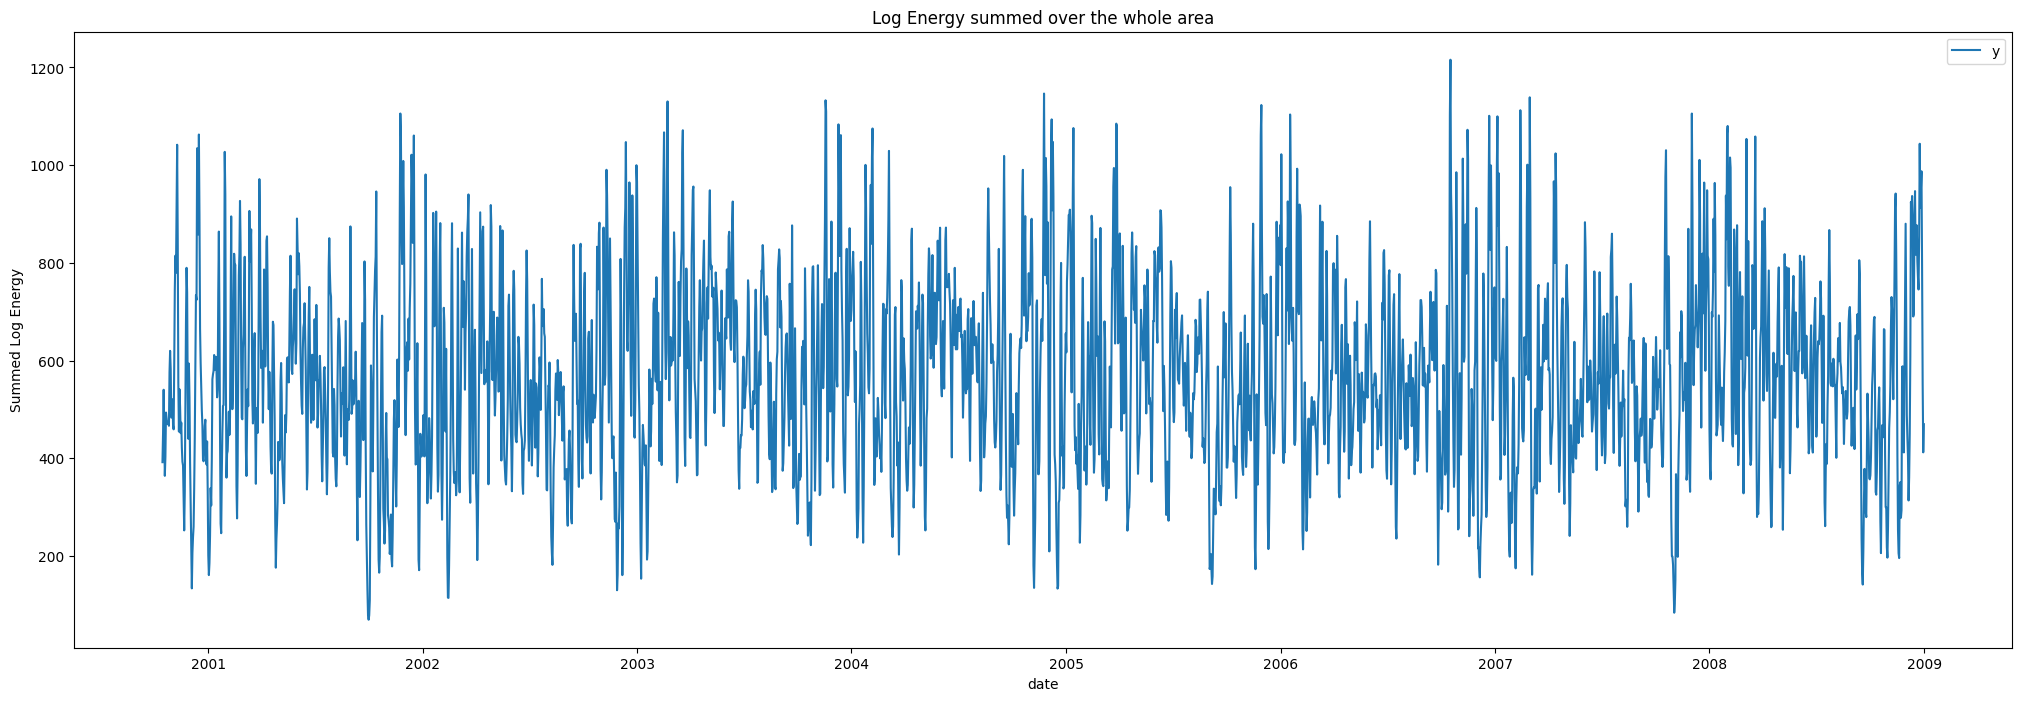

In [6]:
index = test_df['ds'][:n]


def cubic_root_positive(series: pd.Series) -> pd.Series:
    # Convert series to numpy array for vectorized operations
    arr = series.to_numpy()
    
    # For values > 0, take cube root; for values <= 0, set to 0
    arr_transformed = np.where(arr > 0, arr ** (1.0/3.0), 0.0)
    
    # Convert the numpy array back to a pandas Series
    return pd.Series(arr_transformed, index=series.index)


test_df["y"] = cubic_root_positive(test_df["y"])



# Setting up the plot
plt.figure(figsize=(25, 8))
for col in df.columns:
    if col == 'y':
        print(col)
        if col != 'ds' and col !='unique_id' and col != 'start_date' and col != 'end_day':
            daaata = test_df[col].values.reshape(n_time_series,n).sum(axis=0)
            plt.plot(index, daaata, label=col)
        
plt.title('Log Energy summed over the whole area')
plt.xlabel('date')
plt.ylabel('Summed Log Energy')
# plt.grid()
plt.legend()


y


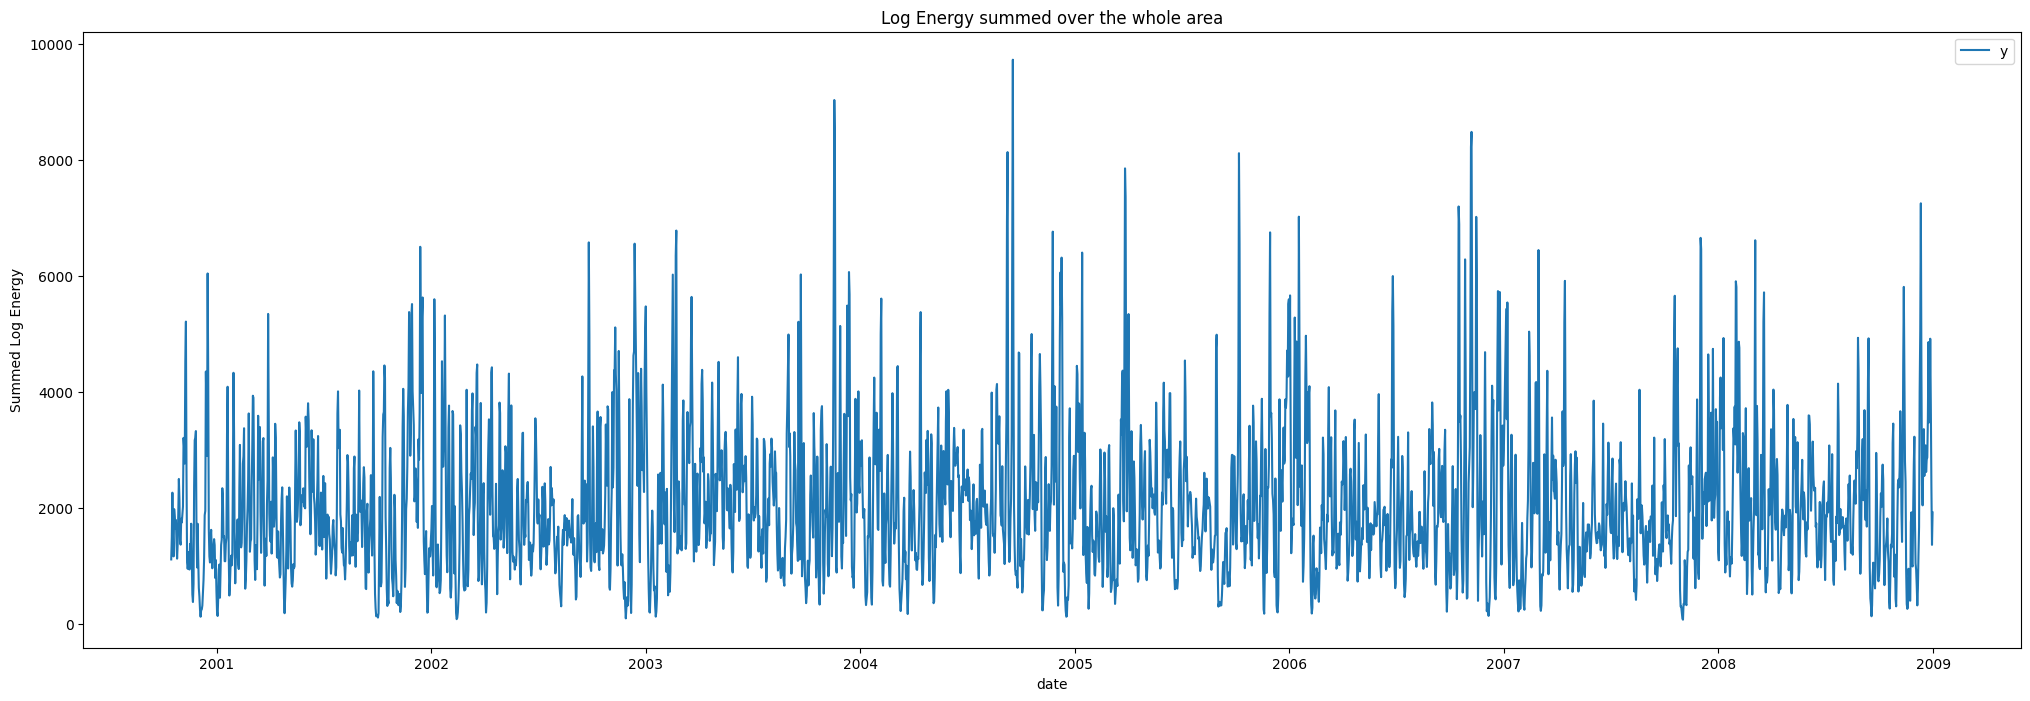

In [4]:
index = test_df['ds'][:n]


# Setting up the plot
plt.figure(figsize=(25, 8))
for col in df.columns:
    if col == 'y':
        print(col)
        if col != 'ds' and col !='unique_id' and col != 'start_date' and col != 'end_day':
            daaata = test_df[col].values.reshape(n_time_series,n).sum(axis=0)
            plt.plot(index, daaata, label=col)
        
plt.title('Log Energy summed over the whole area')
plt.xlabel('date')
plt.ylabel('Summed Log Energy')
# plt.grid()
plt.legend()


In [5]:
import os

# List to hold data from each .pkl file
data_frames = []

flag = 0
for filename in os.listdir('./'):
    if filename.endswith('.pkl'):
        data_frame = pd.read_pickle(filename)
        if  flag == 1 :
            data_frame = data_frame.drop(['unique_id', 'ds', 'y'], axis=1)
        data_frames.append(data_frame)
        flag = 1
        print(filename)

# Concatenate all dataframes horizontally
results_df = pd.concat(data_frames, axis=1)

results_df = results_df[['unique_id', 'ds', 'y', 'DilatedRNN', 'TFT', 'LSTM', 'TCN', 'TiDE', 'TimesNet', 'TimeLLM', 'TSMixer', 'TSMixer-TrafficL', 'TSMixer-M4', 'PatchTST-TrafficL', 'PatchTST-Weather', 'PatchTST-M4', 'iTransformer-M4', 'iTransformer-TrafficL']]
# # Show the concatenated DataFrame
print(results_df)



DilatedRNN_prcp.pkl
TimesNet_prcp.pkl
TFT_prcp.pkl
iTransformer-M4_prcp.pkl
TiDE_prcp.pkl
TCN_prcp.pkl
PatchTST-Weather_prcp.pkl
TSMixer_prcp.pkl
TSMixer-TrafficL_prcp.pkl
PatchTST-TrafficL_prcp.pkl
TimeLLM_prcp.pkl
PatchTST-M4_prcp.pkl
TSMixer-M4_prcp.pkl
TimeLLM-untuned_prcp.pkl
LSTM_prcp.pkl
iTransformer-TrafficL_prcp.pkl
        unique_id         ds       y  DilatedRNN        TFT       LSTM  \
0         1013500 2000-10-15    1.32    5.243925   4.556545   3.757282   
1         1013500 2000-10-16    0.01    0.471088  -0.576547   0.467231   
2         1013500 2000-10-17    0.00    0.944711   0.713979   0.728021   
3         1013500 2000-10-18    6.23    1.205182   0.485369   1.158728   
4         1013500 2000-10-19    3.07    7.654356   7.380338   8.275459   
...           ...        ...     ...         ...        ...        ...   
2012995  14400000 2008-12-27   87.46   22.917757  25.285467  24.871161   
2012996  14400000 2008-12-28  141.28   77.956505  50.397327  75.307487   
2012997

In [6]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def normalized_nash_sutcliffe_efficiencySTavg(y_true, y_pred):  # axis 0 space 1 time
    NSE = 1 - np.sum(np.square(y_true - y_pred)) / np.sum(np.square(y_true - np.mean(y_true)))
    return 1 / (2 - NSE)

def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def r_squared(y_true, y_pred):
    ss_res = np.sum(np.square(y_true - y_pred))
    ss_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (ss_res / ss_tot)

# Models for which metrics are to be calculated
model_columns = ['LSTM', 'DilatedRNN', 'TFT', 'TCN', 'TiDE', 'TimesNet', 'TimeLLM', 'TSMixer', 'TSMixer-TrafficL', 'TSMixer-M4', 'PatchTST-TrafficL', 'PatchTST-Weather', 'PatchTST-M4', 'iTransformer-M4', 'iTransformer-TrafficL']
metrics = ['MSE', 'MAE', 'NNSE', 'R²']

# Initialize an empty DataFrame to store metrics for each model
metrics_df = pd.DataFrame(index=model_columns, columns=metrics)

# Calculate metrics for each model and store in DataFrame
for model in model_columns:
    Y_ACTUAL = results_df['y'].values.reshape(n_time_series,n)
    Y_HAT = results_df[model].values.reshape(n_time_series,n)
    
    mae = mean_absolute_error(Y_ACTUAL, Y_HAT)
    mse = mean_squared_error(Y_ACTUAL, Y_HAT)
    nnse = normalized_nash_sutcliffe_efficiencySTavg(Y_ACTUAL, Y_HAT)
    r2 = r_squared(Y_ACTUAL, Y_HAT)
    
    metrics_df.loc[model] = [mse, mae, nnse, r2] # , first_nnse_val, second_nnse_val




    metrics_df = metrics_df.sort_values(by='MSE', ascending= False)

# Set display option
pd.set_option('display.float_format', '{:.5f}'.format)
metrics_df

,MSE,MAE,NNSE,R²
TSMixer,38.80763,3.30689,0.54557,0.16705
TSMixer-M4,36.14372,3.16943,0.56313,0.22422
iTransformer-TrafficL,33.86793,2.83623,0.57906,0.27307
iTransformer-M4,33.60532,2.93150,0.58096,0.27871
TSMixer-TrafficL,32.24909,2.87327,0.59095,0.30782
PatchTST-Weather,31.63452,2.81840,0.59560,0.32101
TimesNet,30.77483,2.78951,0.60221,0.33946
TimeLLM,30.54253,2.68888,0.60403,0.34445
TCN,30.17772,2.61374,0.60690,0.35228
PatchTST-TrafficL,30.10851,2.75112,0.60745,0.35376


In [16]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def normalized_nash_sutcliffe_efficiencySTavg(y_true, y_pred):  # axis 0 space 1 time
    NSE = 1 - np.sum(np.square(y_true - y_pred)) / np.sum(np.square(y_true - np.mean(y_true)))
    return 1 / (2 - NSE)

def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def r_squared(y_true, y_pred):
    ss_res = np.sum(np.square(y_true - y_pred))
    ss_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (ss_res / ss_tot)

# Models for which metrics are to be calculated
model_columns = ['LSTM', 'DilatedRNN', 'TFT', 'TCN', 'TiDE', 'TimesNet', 'TimeLLM', 'TSMixer-TrafficL', 'TSMixer-M4', 'PatchTST-TrafficL', 'PatchTST-Weather', 'PatchTST-M4', 'iTransformer-M4', 'iTransformer-TrafficL']
metrics = ['MSE', 'MAE', 'NNSE', 'R²'] 

# Initialize an empty DataFrame to store metrics for each model
metrics_df = pd.DataFrame(index=model_columns, columns=metrics)

# Calculate metrics for each model and store in DataFrame
for model in model_columns:
    Y_ACTUAL = results_df['y'].values.reshape(n_time_series,n)[:, -1000:]
    Y_HAT = results_df[model].values.reshape(n_time_series,n)[:, -1000:]
    
    mae = mean_absolute_error(Y_ACTUAL, Y_HAT)
    mse = mean_squared_error(Y_ACTUAL, Y_HAT)
    nnse = normalized_nash_sutcliffe_efficiencySTavg(Y_ACTUAL, Y_HAT)
    r2 = r_squared(Y_ACTUAL, Y_HAT)
    
    metrics_df.loc[model] = [mse, mae, nnse, r2] # , first_nnse_val, second_nnse_val

new_data = {
    'MSE': 26.9578,
    'MAE': 2.54345,
    'NNSE': 0.63052,
    'R²':  0,
}
metrics_df.loc['MultiFoundationPattern'] = new_data
new_data = {
    'MSE': 26.8345,
    'MAE': 2.47731,
    'NNSE': 0.63120,
    'R²': 0,
}
metrics_df.loc['MultiFoundationCore'] = new_data


metrics_df = metrics_df.sort_values(by='MSE', ascending= False)

# Set display option
pd.set_option('display.float_format', '{:.4f}'.format)
metrics_df

,MSE,MAE,NNSE,R²
TSMixer-M4,35.8996,3.1405,0.5623,0.2215
iTransformer-M4,33.0192,2.8941,0.5827,0.2840
iTransformer-TrafficL,32.8197,2.7774,0.5842,0.2883
TSMixer-TrafficL,31.9283,2.8479,0.5909,0.3076
PatchTST-Weather,31.3607,2.7944,0.5952,0.3199
TimesNet,30.7948,2.7750,0.5996,0.3322
TimeLLM,30.4791,2.6698,0.6021,0.3391
TCN,30.2239,2.6142,0.6041,0.3446
PatchTST-TrafficL,29.8829,2.7299,0.6068,0.3520
TiDE,29.8450,2.8262,0.6071,0.3528


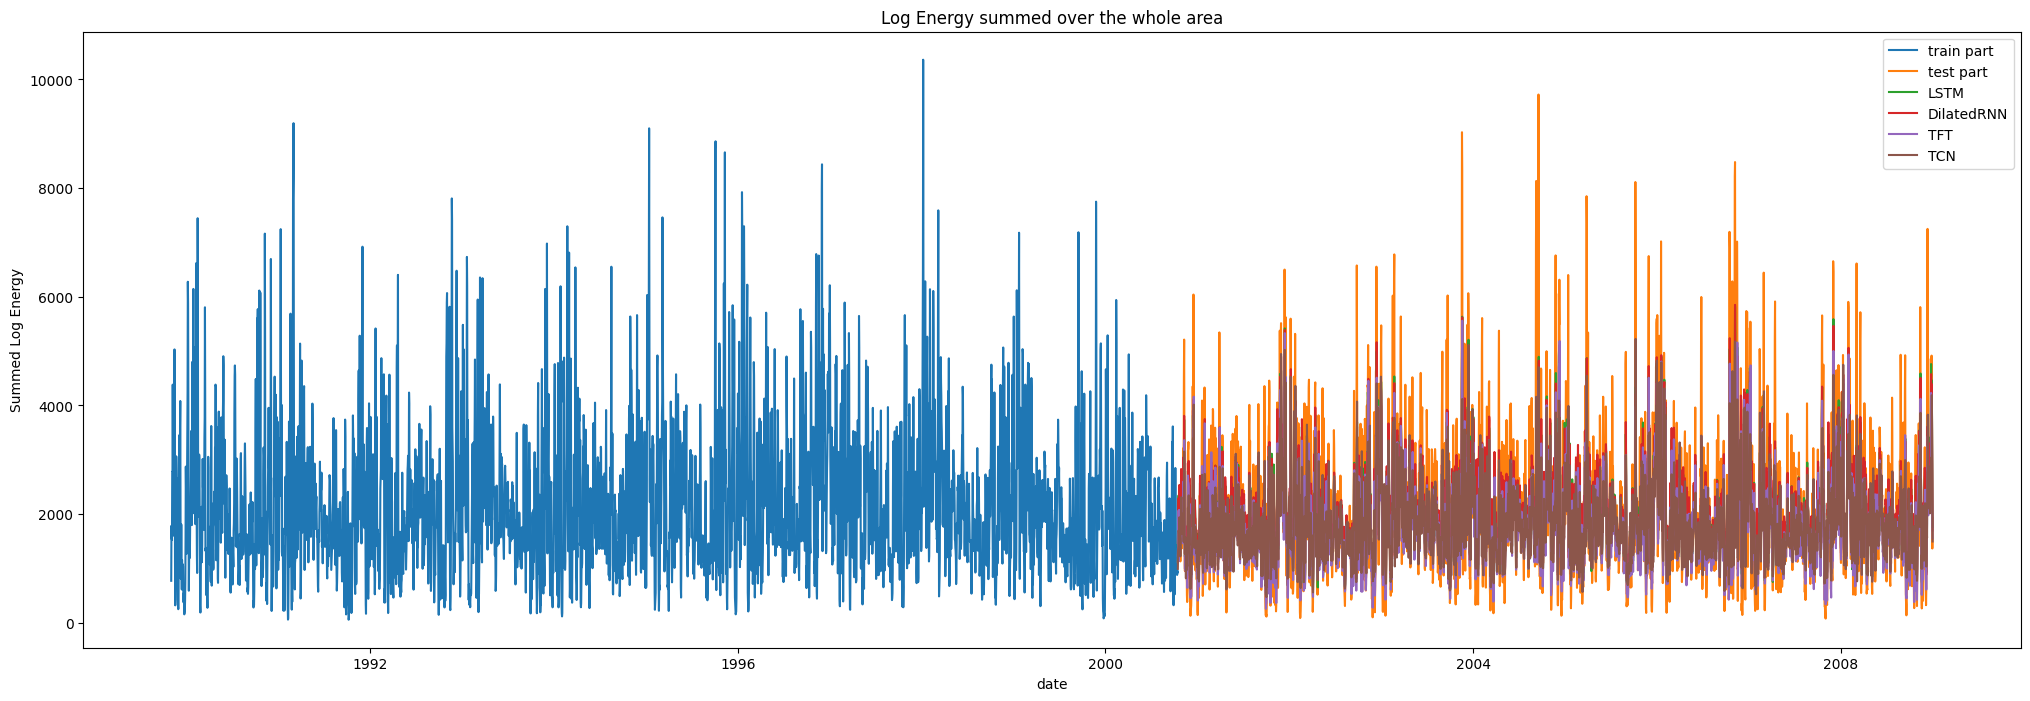

In [8]:
test_actual_y = results_df['y'].values.reshape(n_time_series,n).sum(axis=0)
train_actual_y = train_df['y'].values.reshape(n_time_series,7000-n).sum(axis=0)


index_date_test = results_df[results_df['unique_id'] == 1013500]['ds']
index_date_train = train_df['ds'][:7000-n]


# Setting up the plot
plt.figure(figsize=(25, 8))


plt.plot(index_date_train,train_actual_y, label='train part')
plt.plot(index_date_test, test_actual_y, label='test part')

for model in  ['LSTM', 'DilatedRNN', 'TFT', 'TCN']:
    test_predicted_y = results_df[model].values.reshape(n_time_series,n).sum(axis=0)
    plt.plot(index_date_test, test_predicted_y, label=model)


plt.title('Log Energy summed over the whole area')
plt.xlabel('date')
plt.ylabel('Summed Log Energy')
# plt.grid()
plt.legend()



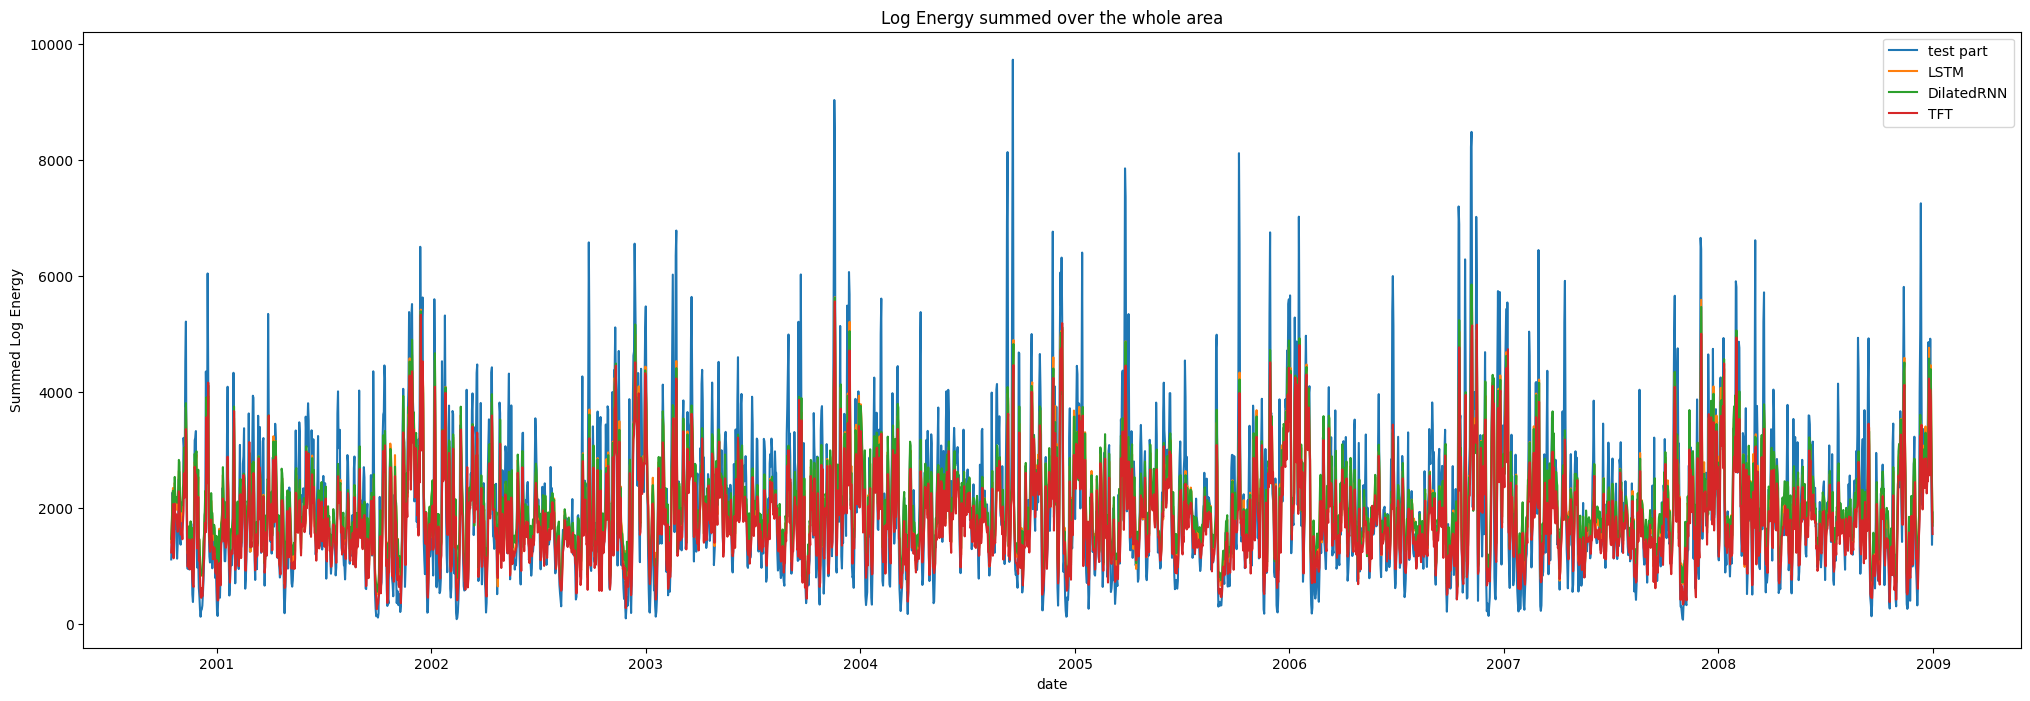

In [9]:
test_actual_y = results_df['y'].values.reshape(n_time_series,n).sum(axis=0)
train_actual_y = train_df['y'].values.reshape(n_time_series,7000-n).sum(axis=0)


index_date_test = results_df[results_df['unique_id'] == 1013500]['ds']
index_date_train = train_df['ds'][:7000-n]


# Setting up the plot
plt.figure(figsize=(25, 8))


plt.plot(index_date_test, test_actual_y, label='test part')

for model in  ['LSTM', 'DilatedRNN', 'TFT']:
    test_predicted_y = results_df[model].values.reshape(n_time_series,n).sum(axis=0)
    plt.plot(index_date_test, test_predicted_y, label=model)


plt.title('Log Energy summed over the whole area')
plt.xlabel('date')
plt.ylabel('Summed Log Energy')
# plt.grid()
plt.legend()

